In [1]:
# 必要なもの
# 対象領域の流域図
# 主河道網
# 標高データ

# 都市内に条件を満たす上下水道が存在しないとき
# A: 主河道 =! 1 and <=limitation 主河道が短すぎる場合は主河道の上下端を浄水場・

In [85]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

#---------------------------------------------------------------------------------------------------------------
# MODULES
#---------------------------------------------------------------------------------------------------------------

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = a - ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

#---------------------------------------------------------------------------------------------------------------
# Main function
#---------------------------------------------------------------------------------------------------------------

def explore(target_index, remove_grid, innercity_grid, width):
    """
    A: After over remove_grid process
    B: After over remove_grid process & over innercity_grid process
    """
    latgrd = 2160 # sum of latitude grids (y)
    longrd = 4320 # sum of longitude grids (x)

#---------------------------------------------------------------------------------------------------------------
#   PATH
#---------------------------------------------------------------------------------------------------------------

    # root directory
    root_dir = "/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city"
    # lonlat data
    city_path = f"{root_dir}/dat/cty_lst_/gpw4/WUP2018_300k_2010.txt"
    # city mask data
    cmsk_dir = f"{root_dir}/dat/vld_cty_/"
    elvmin_path = f"{root_dir}/dat/elv_min_/elevtn.CAMA.gl5"
    pop_path = f"{root_dir}/dat/pop_tot_/GPW4ag__20100000.gl5"
    # riv data
    rivnum_path = f"{root_dir}/dat/riv_num_/rivnum.CAMA.gl5"
    rivara_path = f"{root_dir}/dat/riv_ara_/rivara.CAMA.gl5"
    rivnxl_path = f"{root_dir}/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivout_path = f"{root_dir}/dat/riv_out_/W5E5LR__20190000.gl5"

#---------------------------------------------------------------------------------------------------------------
#   City Lon Lat Information
#---------------------------------------------------------------------------------------------------------------

    """
    first line of all_lines
    1 35.6895 139.6917 36859.626 Tokyo """

    # city_list.txtを開いてデータを読み取る
    with open(city_path, "r") as input_file:
        lines = input_file.readlines()

    line = lines[target_index-1] # 対象となる都市の情報行を参照
    parts = line.split('\t') # 各行をスペースで分割
    parts = [item.strip() for item in parts]
    city_num = int(parts[0]) # 都市番号
    cnt_lat = float(parts[1]) # 都市中心の緯度
    cnt_lon = float(parts[2]) # 都市中心の経度
    city_name = parts[4].replace("\"", "").replace("?", "").replace("/", "") # 都市名

    # widthを使用して外枠の座標を計算
    lonmin = float(cnt_lon - width)
    lonmax = float(cnt_lon + width)
    latmin = float(cnt_lat - width)
    latmax = float(cnt_lat + width)

    print(f"city_num {city_num}")
    print(city_name)

#---------------------------------------------------------------------------------------------------------------
#   Get Lon Lat
#---------------------------------------------------------------------------------------------------------------

    """Calculate the indices corresponding to the desired latitudes and longitudes"""
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat_length = np.linspace(-90, 90, latgrd+1)
    lon_length = np.linspace(-180, 180, longrd+1)
    lat_start, lat_end = np.searchsorted(lat_length, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon_length, [lonmin, lonmax])

    # adjust to 0.25 grid
    # 緯度経度の始点グリッドのインデックス
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1
    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1

    # 計算領域である正方形の一辺に含まれるグリッド数 (1degree = 12 grids x 12 grids)
    width_grid = width * 12 * 2

    # 緯度経度の終点グリッドのインデックス
    lat_end = lat_start + width_grid
    lon_end = lon_start + width_grid

#---------------------------------------------------------------------------------------------------------------
#   Load city mask data (g_mask_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_mask = np.fromfile(f'{cmsk_dir}/city_{city_num:08d}.gl5', 'float32').reshape(latgrd, longrd)
    g_mask = np.flipud(g_mask)
    g_mask = np.ma.masked_where(g_mask >= 1E20, g_mask)
    g_mask_cropped = g_mask[lat_start:lat_end, lon_start:lon_end]
    g_mask_cropped = np.flipud(g_mask_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#  Load population
#---------------------------------------------------------------------------------------------------------------
    
    g_pop = np.fromfile(pop_path, 'float32').reshape(latgrd, longrd)
    g_pop = np.flipud(g_pop)
    g_pop = np.ma.masked_where(g_pop >= 1e20, g_pop)
    g_pop_cropped = g_pop[lat_start:lat_end, lon_start:lon_end]
    g_pop_cropped = np.flipud(g_pop_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#   Load elevation data (g_elv_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_elv = np.fromfile(elvmin_path, 'float32').reshape(latgrd, longrd)
    g_elv = np.flipud(g_elv)
    g_elv = np.ma.masked_where(g_elv >= 1E20, g_elv)
    g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
    g_elv_cropped = np.flipud(g_elv_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#   Load river discharge (g_rivout_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_rivout = np.fromfile(rivout_path, 'float32').reshape(latgrd, longrd)
    g_rivout = np.flipud(g_rivout)
    g_rivout = np.ma.masked_where(g_rivout >= 1E20, g_rivout)
    g_rivout_cropped = g_rivout[lat_start:lat_end, lon_start:lon_end]
    g_rivout_cropped = np.flipud(g_rivout_cropped)

#---------------------------------------------------------------------------------------------------------------
#   Load basin data (g_rivnum_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(latgrd, longrd)
    g_rivnum = np.flipud(g_rivnum)
    g_rivnum = np.ma.masked_where(g_rivnum >= 1E20, g_rivnum)
    g_rivnum_cropped = g_rivnum[lat_start:lat_end, lon_start:lon_end]
    g_rivnum_cropped = np.flipud(g_rivnum_cropped)
    g_rivnum_cropped = np.ma.masked_where(~np.isfinite(g_rivnum_cropped) | (g_rivnum_cropped == 0), g_rivnum_cropped)

#---------------------------------------------------------------------------------------------------------------
#   Load upper river catchment area (g_rivara_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_rivara = np.fromfile(rivara_path, 'float32').reshape(latgrd, longrd)
    g_rivara = np.flipud(g_rivara)
    g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
    g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
    g_rivara_cropped = np.flipud(g_rivara_cropped)
    g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

#---------------------------------------------------------------------------------------------------------------
#   Load river's next l coordinate data (g_rivnxl_cropped)
#---------------------------------------------------------------------------------------------------------------

    g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(latgrd, longrd)
    g_rivnxl = np.flipud(g_rivnxl)
    g_rivnxl = np.ma.masked_where(g_rivnxl >= 1E20, g_rivnxl)
    g_rivnxl_cropped = g_rivnxl[lat_start:lat_end, lon_start:lon_end]
    g_rivnxl_cropped = np.flipud(g_rivnxl_cropped)
    g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)

#---------------------------------------------------------------------------------------------------------------
#   Basin data only where city mask exists (g_rivnum_cropped_city)
#---------------------------------------------------------------------------------------------------------------

    g_rivnum_cropped_city = np.where(g_mask_cropped == 1, g_rivnum_cropped, np.nan)
    g_rivnum_cropped_city = np.ma.masked_where(~np.isfinite(g_rivnum_cropped_city) | (g_rivnum_cropped_city == 0), g_rivnum_cropped_city)

#---------------------------------------------------------------------------------------------------------------
#   3D array consists of g_rivara_cropped + g_rivnum_cropped (g_ara_num_cropped)
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)

    # rivaraとrivnumのデータをg_ara_num_croppedに追加
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = g_rivnum_cropped

#---------------------------------------------------------------------------------------------------------------
#  　Basin over remove_grid (Rivnum_A_array)
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedのrivnumをマスク付き配列として取得
    g_rivnum_cropped_masked = np.ma.masked_array(g_rivnum_cropped, np.isnan(g_rivnum_cropped))

    # マスクされていない要素(Nanじゃない値)のユニークな値とその出現回数を取得
    unique_values_org, counts_org = np.unique(g_rivnum_cropped_masked.compressed(), return_counts=True)
    value_counts_dict = dict(zip(unique_values_org, counts_org))

    # 値（個数）の多い順にソート
    # 都市マスク内の流域番号で，出現回数が多い順に並んでいるはず
    sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))

    # 値（個数）がremove grid以上の項目のみを持つ新しい辞書を作成 ### 流域が小さい物は削除する作業に該当
    filtered_dict_A = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}

    # 空っぽのマスク配列(24x24を作る) ### 24x24は適当に決めてる
    Rivnum_A_array = np.ma.masked_all(g_rivnum_cropped_masked.shape, dtype='float32')

    # filtered_dict_Aのキー(流域ID)に対して繰り返し処理を行い、### それぞれのrivnumがg_rivnum_cropped_maskedに存在する位置を特定します。
    for rivnum_id in filtered_dict_A.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(g_rivnum_cropped_masked.data == rivnum_id)
        # これらの位置に新しい配列にrivnumを設定
        Rivnum_A_array[matching_positions] = rivnum_id

    # Rivnum_A_arrayは都市マスクなしのすべての流域
    Rivnum_A_array = np.ma.masked_where(~np.isfinite(Rivnum_A_array) | (Rivnum_A_array == 0), Rivnum_A_array)

#---------------------------------------------------------------------------------------------------------------
#   Basin over remove_grid within city mask (Rivnum_A_array_citymasked)
#---------------------------------------------------------------------------------------------------------------

    # Rivnum_A_arrayの値が存在しないか、値が0の場所をTrueとするマスクを作成
    invalid_mask = np.isnan(Rivnum_A_array) | (Rivnum_A_array == 0)
    # g_mask_croppedが1でない場所、または上記のマスクがTrueの場所をマスクとして指定
    Rivnum_A_array_citymasked = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_A_array)

#---------------------------------------------------------------------------------------------------------------
#   マスクされていない要素のユニークな値とその出現回数を取得(unique_values_A)
#---------------------------------------------------------------------------------------------------------------

    unique_values_A, counts_A = np.unique(Rivnum_A_array_citymasked.compressed(), return_counts=True)
    value_counts_dict_A = dict(zip(unique_values_A, counts_A))

#---------------------------------------------------------------------------------------------------------------
#   rivaraを使って河口グリッドを探索する (rivara_max_array_A)
#---------------------------------------------------------------------------------------------------------------

    # データ型とサイズに基づいて新しい配列を作成
    rivara_max_array_A = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')

    for rivnum_id in value_counts_dict_A.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(Rivnum_A_array_citymasked == rivnum_id)
        # これらの位置におけるrivaraの最大値の位置を取得
        max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])
        # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
        # 河口グリッドに該当
        rivara_max_array_A[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

#---------------------------------------------------------------------------------------------------------------
#   riv nxtl -> lonlat coordinate array 24x24x2 (riv_nxlonlat_cropped)
#---------------------------------------------------------------------------------------------------------------

    # l coordiate to lonlat coordinate
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxlonlat = np.empty(g_rivnxl_cropped.shape, dtype=tuple)
    mask = ~np.isnan(g_rivnxl_cropped)
    riv_nxlonlat[mask] = vfunc(g_rivnxl_cropped[mask])
    riv_nxlonlat_shape = (riv_nxlonlat.shape[0], riv_nxlonlat.shape[1], 2)

    riv_nxlonlat_lst = []
    for row in riv_nxlonlat:
        for x, y in row:
            # width_grid = cropped scale(24x24)
            modified_x = width_grid - (x - lat_start)
            modified_y = y - lon_start
            riv_nxlonlat_lst.append((modified_x, modified_y))

    riv_nxlonlat_cropped = np.array(riv_nxlonlat_lst).reshape(riv_nxlonlat_shape)
    riv_nxlonlat_cropped = riv_nxlonlat_cropped.astype(int)

#---------------------------------------------------------------------------------------------------------------
#   各流域の経路座標　(path_dict)
#   各経路が流域番号で格納され，1つのファイルに集約 (riv_path_array_A)
#---------------------------------------------------------------------------------------------------------------

    # 保存用の変数を設定
    path_dict_A = {}
    riv_path_array_A = np.ma.masked_all(rivara_max_array_A.shape, dtype='float32')
    visited_coords = set()

    # マスク内の流域IDごとにループ
    for uid in unique_values_A:
        # 河口グリッドのインデックス
        coords_a = np.argwhere(rivara_max_array_A == uid)
        riv_path_array_A[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(len(g_mask_cropped)):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                # riv_nxlonlat_croppedはrivnxlのlonlat表示なので
                # target_coordを次のセルに指し示すrivnxlのインデックスを取得
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                # マッチしたインデックスの中でrivaraが最大のものを選ぶ
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                # g_rivara_croppedに座標をいれて，最大最小を比べている
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                # 河口グリッドのファイルに経路をそれぞれ足していく
                riv_path_array_A[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                # path_coordに経路を足していく
                path_coords.append(target_coord)

            # 各流域の経路を保存
            path_dict_A[uid] = path_coords

#---------------------------------------------------------------------------------------------------------------
#   Rivpath over innercity_grid (riv_path_city_B)
#---------------------------------------------------------------------------------------------------------------

    # city mask
    fill_value = 1e20
    riv_path_array_filled = riv_path_array_A.filled(fill_value)
    riv_path_city_A = np.where(g_mask_cropped==1, riv_path_array_filled, fill_value)

    # make new array
    riv_path_city_B = copy.deepcopy(riv_path_city_A)

    for uid in unique_values_A:
        count = 0
        mask = (riv_path_city_A == uid)
        count = np.sum(mask)
        # もし主河道のセル数が都市マスク内で指定の値より少ない場合削除
        if count < innercity_grid:
            riv_path_city_B[riv_path_city_B== uid] = fill_value

    riv_path_city_B = np.ma.masked_where(riv_path_city_B >= fill_value, riv_path_city_B)

#---------------------------------------------------------------------------------------------------------------
#   Update unique river basin number after 2 removing process (unique_values_B)
#---------------------------------------------------------------------------------------------------------------

    # compressed()を行わないとマスク値がunique_valueとしてカウントされてしまう
    unique_values_B, _ = np.unique(riv_path_city_B.compressed(), return_counts=True)

#---------------------------------------------------------------------------------------------------------------
#   都市マスク内に存在する流域を全範囲で取得(Rivnum_B_array)
#---------------------------------------------------------------------------------------------------------------

    # 新しい配列を作成
    Rivnum_B_array = np.ma.masked_all(g_rivnum_cropped_masked.shape, dtype='float32')

    # Rivnum_A_arrayに存在する新しいunique_id地点のみを保存
    for uid in unique_values_B:
        row_indices, col_indices = np.where(Rivnum_A_array == uid)
        Rivnum_B_array[row_indices, col_indices] = uid

#---------------------------------------------------------------------------------------------------------------
#   Updated river mouse grid (rivara_max_array_B)
#---------------------------------------------------------------------------------------------------------------

    # データ方とサイズに基づいて新しい配列を作成
    rivara_max_array_B = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')

    for rivnum_id in unique_values_B:
        # 同じrivnumの位置を取得
        matching_positions = np.where(Rivnum_A_array_citymasked == rivnum_id)
        # これらの位置におけるrivaraの最大値の位置を取得
        max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])
        # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
        rivara_max_array_B[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

#---------------------------------------------------------------------------------------------------------------
#   Update riv_path_array with full length out of city mask (riv_path_array_B)
#---------------------------------------------------------------------------------------------------------------

    # 保存用の変数を設定
    path_dict_B = {}
    riv_path_array_B = np.ma.masked_all(rivara_max_array_B.shape, dtype='float32')
    visited_coords = set()

    # マスク内の流域IDごとにループ
    for uid in unique_values_B:
        # 河口グリッドのインデックス
        coords_a = np.argwhere(rivara_max_array_B == uid)
        riv_path_array_B[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(len(g_mask_cropped)):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                # riv_nxlonlat_croppedはrivnxlのlonlat表示なので
                # target_coordを次のセルに指し示すrivnxlのインデックスを取得
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                # マッチしたインデックスの中でrivaraが最大のものを選ぶ
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                # g_rivara_croppedに座標をいれて，最大最小を比べている
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                # 河口グリッドのファイルに経路をそれぞれ足していく
                riv_path_array_B[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                # path_coordに経路を足していく
                path_coords.append(target_coord)

            # 各流域の経路を保存
            path_dict_B[uid] = path_coords

#---------------------------------------------------------------------------------------------------------------
#   Explore josui grids (josui_lst)
#---------------------------------------------------------------------------------------------------------------

    # determine josui place
    josui_lst = []

    # loop uid
    for key_num in unique_values_B:
        # get river path
        indices = np.argwhere(riv_path_city_B == key_num)
        # get minmum river area
        rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in indices]
        min_arg = np.argmin(rivara_values)
        josui = indices[min_arg]
        # add to list
        josui_lst.append(josui)

#---------------------------------------------------------------------------------------------------------------
#   Josui map 24 x 24 (josui_array)
#---------------------------------------------------------------------------------------------------------------

    # 浄水場情報を24x24のマスクファイルに保存
    josui_array = np.ma.masked_all(rivara_max_array_B.shape, dtype='float32')

    for matching_position, uid in zip(josui_lst, unique_values_B):
        josui_array[matching_position[0], matching_position[1]] = uid

#---------------------------------------------------------------------------------------------------------------
#   Save file (josui_array)
#---------------------------------------------------------------------------------------------------------------

    """
    croppするときは必ずひっくり返す
    保存・描写するときにもとに戻す
    """

    # 保存用ファイル作成
    josui_for_save = np.ma.masked_all(g_rivara.shape, dtype='float32')

    #　cropp区間の値を変換(世界地図はひっくり返っている)
    josui_for_save[lat_start:lat_end, lon_start:lon_end] = np.flipud(josui_array)

    # 浄水場を1, それ以外を0とするバイナリーファイルに変換
    josui_for_save = np.ma.filled(josui_for_save, fill_value=0)
    josui_for_save = np.where(josui_for_save > 0, 1, josui_for_save)

    # debug用
    #josui_cropped = josui_for_save[lat_start:lat_end, lon_start:lon_end]
    #josui_cropped = np.flipud(josui_cropped)
    #plt.imshow(josui_cropped)
    #plt.show()

    # 保存するときは世界地図をひっくり返して，正しい向きにしておく
    josui_for_save = np.flipud(josui_for_save)

#---------------------------------------------------------------------------------------------------------------
#   Save file (gesui_array=rivara_max_array_B)
#---------------------------------------------------------------------------------------------------------------

    """
    croppするときは必ずひっくり返す
    保存・描写するときにもとに戻す
    """

    # 保存用ファイル作成
    gesui_for_save = np.ma.masked_all(g_rivara.shape, dtype='float32')

    #　cropp区間の値を変換(世界地図はひっくり返っている)
    gesui_for_save[lat_start:lat_end, lon_start:lon_end] = np.flipud(rivara_max_array_B)

    # 浄水場を1, それ以外を0とするバイナリーファイルに変換
    gesui_for_save = np.ma.filled(gesui_for_save, fill_value=0)
    gesui_for_save = np.where(gesui_for_save > 0, 1, gesui_for_save)

    # debug用
    #gesui_cropped = gesui_for_save[lat_start:lat_end, lon_start:lon_end]
    #gesui_cropped = np.flipud(gesui_cropped)
    #plt.imshow(gesui_cropped)
    #plt.show()

    # 保存するときは世界地図をひっくり返して，正しい向きにしておく
    gesui_for_save = np.flipud(gesui_for_save)

    img_extent = (lon_length[lon_start], lon_length[lon_end], lat_length[lat_start], lat_length[lat_end])
    return (
                [lon_start, 
                 lon_end, 
                 lat_start, 
                 lat_end, 
                 img_extent,
                 Rivnum_A_array,
                 g_mask_cropped,
                 rivara_max_array_A,
                 g_pop_cropped,
                 riv_path_array_A,
                 path_dict_A,
                 riv_path_array_B,
                 path_dict_B,
                 g_elv_cropped,
                 g_rivout_cropped,
                ]
    )

In [86]:
def main():
#---------------------------------------------------------------------------------------------------------------
#   Initialization
#---------------------------------------------------------------------------------------------------------------

    remove_grid = 5 # minimum number of grids in one basin
    innercity_grid = 3 # minimum number of main river grid within city mask
    width = 1 # lonlat delta degree from city center

#---------------------------------------------------------------------------------------------------------------
#   get variables
#---------------------------------------------------------------------------------------------------------------

    target_index = 7 #new york
    result = explore(target_index, remove_grid, innercity_grid, width)
    return result
    
result = main()
print(len(result))

city_num 7
New York-Newark
15


In [66]:
import os
import copy
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

projection = ccrs.PlateCarree()
extent = result[4]

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

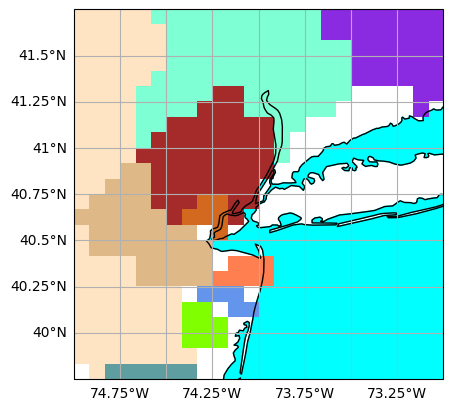

In [111]:
#---------------------------------------------------------------------------------------------------------------
#  Basinの図を作図する
#---------------------------------------------------------------------------------------------------------------

def plot_A_basin(data, Rivnum_masked_array):
    # cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # draw
    plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.coastlines()
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors)

plot_A_basin(result[5], result[5])

(<GeoAxes: >, <matplotlib.image.AxesImage at 0x7f3acaef79a0>)

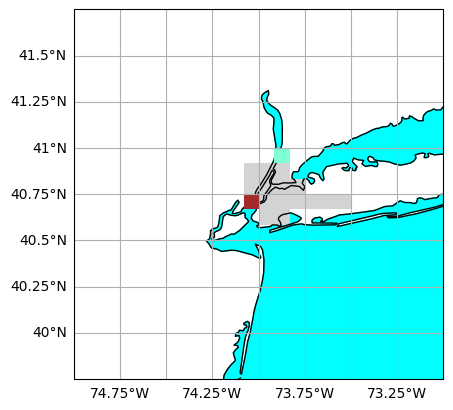

In [112]:
#---------------------------------------------------------------------------------------------------------------
#  City_areaを作図
#---------------------------------------------------------------------------------------------------------------

def plot_citymask(citymask, data, Rivnum_masked_array):
    
    # basin cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # city cmap 
    cmap_gray = colors.ListedColormap(['none', 'lightgray'])
    bounds_gray = [0, 0.5, 1]
    norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)
    
    # draw
    plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.coastlines()
    img = ax.imshow(indexed_data,
                    origin='upper', extent=extent, transform=projection,
                    cmap=cmap, vmin=-1, vmax=num_colors, 
                    zorder=2)
    img_gray = ax.imshow(citymask, 
                         origin='upper', extent=extent, transform=projection, 
                         cmap=cmap_gray, norm=norm_gray, 
                         zorder=1)
    return ax, img

plot_citymask(result[6], result[7], result[5])

2.736897 1143515.1


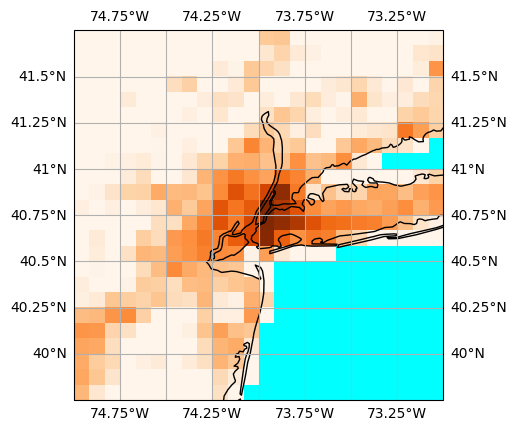

In [109]:
#---------------------------------------------------------------------------------------------------------------
# 人口をプロットする
#---------------------------------------------------------------------------------------------------------------

def plot_population(g_pop_cropped):
    # draw
    g_pop_cropped = np.ma.masked_where(g_pop_cropped == 0, g_pop_cropped)
    pop_vmin = np.min(g_pop_cropped)
    pop_vmax = np.max(g_pop_cropped)
    print(pop_vmin, pop_vmax)
    
    plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.coastlines()
    
    img = ax.imshow(g_pop_cropped,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='Oranges',
                norm=colors.LogNorm(vmin=1e4, vmax=pop_vmax)
    ) 

plot_population(result[8])

0.4 338.4


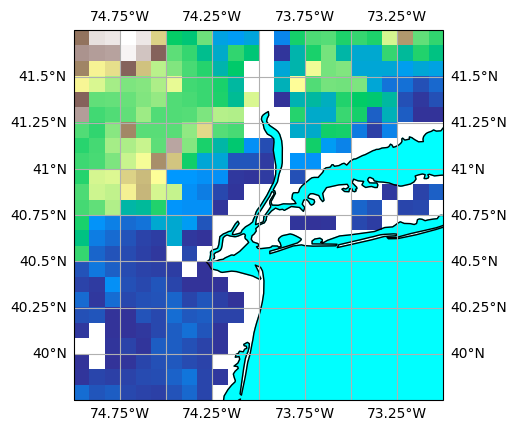

In [107]:
#---------------------------------------------------------------------------------------------------------------
# 標高をプロットする
#---------------------------------------------------------------------------------------------------------------

def plot_elevation(elevation):
    # draw
    elevation = np.ma.masked_where(elevation == 0, elevation)
    elv_vmin = np.min(elevation)
    elv_vmax = np.max(elevation)
    print(elv_vmin, elv_vmax)
    
    plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.coastlines()
    
    img = ax.imshow(elevation,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='terrain',
    ) 

plot_elevation(result[13])

1359.7361 1337993.9


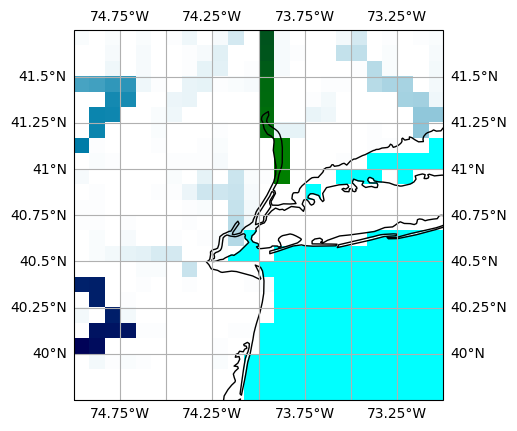

In [108]:
#---------------------------------------------------------------------------------------------------------------
# 流量をプロットする
#---------------------------------------------------------------------------------------------------------------

def plot_discharge(discharge):
    # draw
    discharge = np.ma.masked_where(discharge == 0, discharge)
    dis_vmin = np.min(discharge)
    dis_vmax = np.max(discharge)
    print(dis_vmin, dis_vmax)
    
    plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.coastlines()
    
    img = ax.imshow(discharge,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='ocean_r',
    ) 

plot_discharge(result[14])

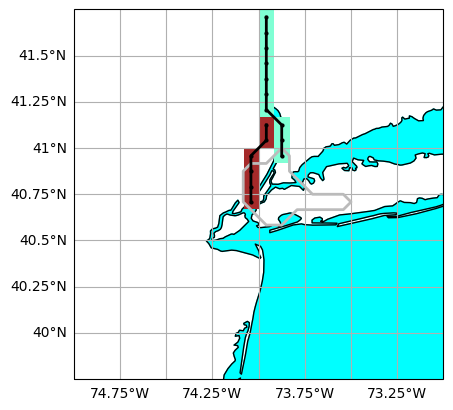

In [113]:
#---------------------------------------------------------------------------------------------------------------
# RivPathの図を描く
#---------------------------------------------------------------------------------------------------------------

def plot_path_zorder(data, city_mask, Rivnum_masked_array, results_dict=None, width=1):
    # cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # draw
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー
    
    # city maskをコンターで描く
    contour = ax.contour(city_mask, levels=[0.5], colors=light_gray, linewidths=2, origin='upper', extent=extent, transform=projection, zorder=3)

    # labels
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels

    # ocean
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.add_feature(cfea.LAKES, color='#00FFFF')
    ax.coastlines()
    
    # rivpath
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors, zorder=2)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー

    # path to paths
    if results_dict is not None:
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=2, color='black', linestyle='-', linewidth=2, transform=projection, zorder=5)

plot_path_zorder(result[9], result[6], result[5], results_dict=result[10])

city_num 7
New York-Newark
15
0.4 338.4
1359.7361 1337993.9
2.736897 1143515.1


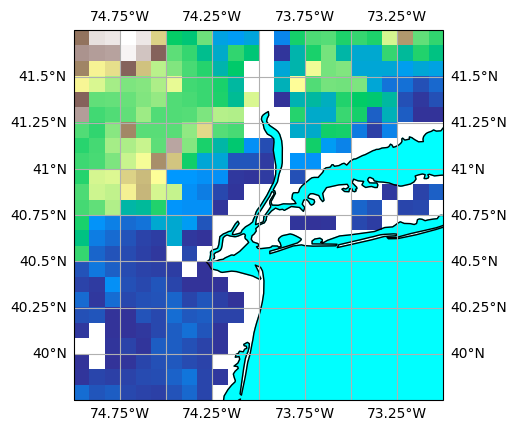

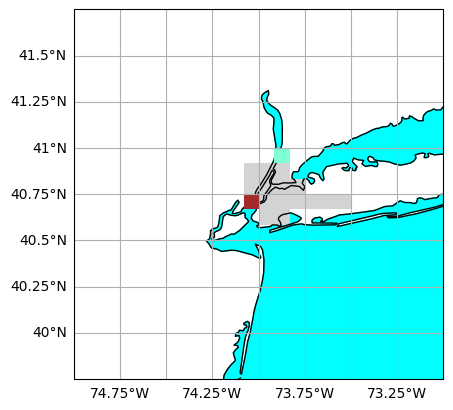

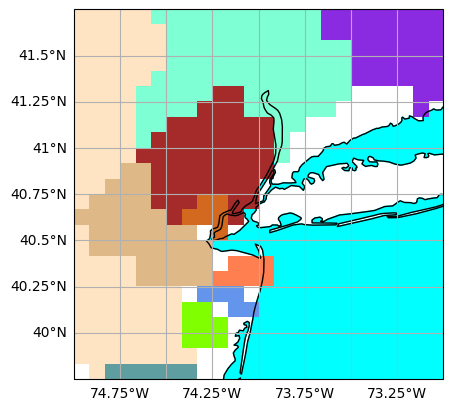

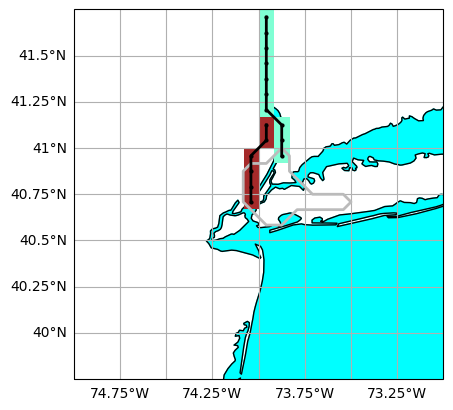

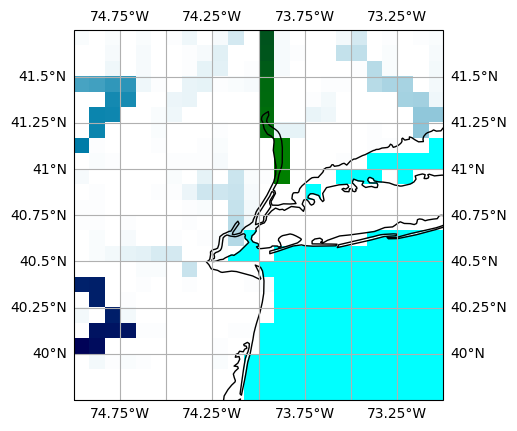

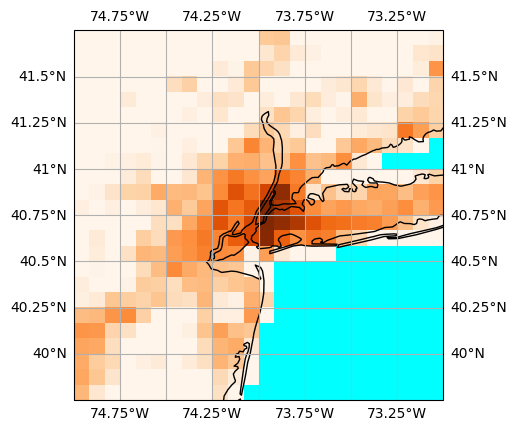

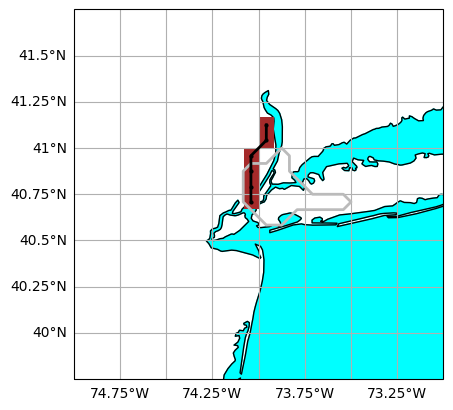

In [114]:
def main():
#---------------------------------------------------------------------------------------------------------------
#   Initialization
#---------------------------------------------------------------------------------------------------------------

    remove_grid = 5 # minimum number of grids in one basin
    innercity_grid = 3 # minimum number of main river grid within city mask
    width = 1 # lonlat delta degree from city center

#---------------------------------------------------------------------------------------------------------------
#   get variables
#---------------------------------------------------------------------------------------------------------------

    target_index = 7 #new york
    result = explore(target_index, remove_grid, innercity_grid, width)
    return result
    
result = main()
print(len(result))
plot_elevation(result[13])
plot_citymask(result[6], result[7], result[5])
plot_A_basin(result[5], result[5])
plot_path_zorder(result[9], result[6], result[5], results_dict=result[10])
plot_discharge(result[14])
plot_population(result[8])
plot_path_zorder(result[11], result[6], result[5], results_dict=result[12])